# Deep Fake Detection. MnasNet

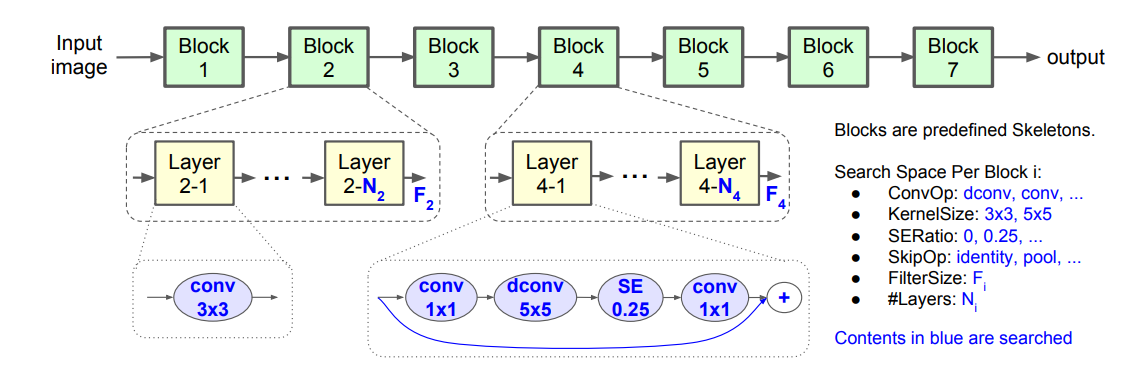

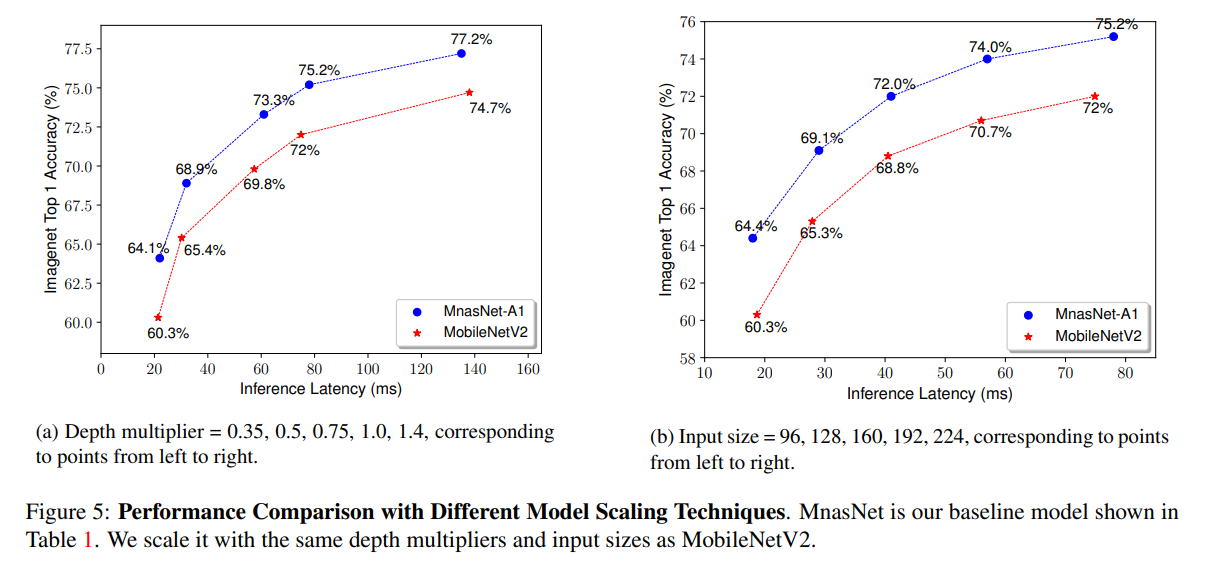

MnasNet model is a mobile architecture that is designed for mobile devices. It is a lightweight model that is suit
for mobile devices. It's based on MobileNetV2 and uses depthwise separable convolutions to build lightweight deep neural networks. For more information about MnasNet, please refer to the paper [MnasNet: Platform-Aware Neural Architecture Search for Mobile](https://arxiv.org/pdf/1807.11626.pdf).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as transforms

from torch.optim import lr_scheduler

from torch.utils.data import random_split, DataLoader
from dataset_handlers.feature_dataset import FeatureDataset

import os
from PIL import Image
from matplotlib import pyplot as plt

In [61]:
mna_net = models.mnasnet0_75(weights='MNASNet0_75_Weights.IMAGENET1K_V1')

## Transfer Learning

In [102]:
model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(216320),
    nn.Dropout(0.5),
    nn.Linear(216320, 2)
)

Comenzamos el proceso de entrenamiento

In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [104]:
def accuracy(data_loader, model, transform):
    acc = 0
    for i, (image, label) in enumerate(data_loader, 1):
        image = image.to(device)
        label = label.to(device)

        image = transform(image)

        output = model(image).reshape(-1, 2)
        acc += (torch.argmax(output, dim=1) == label).sum().item()

    return acc / len(data_loader.dataset)

In [130]:
def train_model(model, transform, criterion, optimizer, epochs, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader):
    for epoch in range(epochs):
        for i, (image, label) in enumerate(train_loader, 1):
            image = image.to(device)
            label = label.to(device)

            image = transform(image)
            output = model(image)

            loss = criterion(output, label)

            l1_regularization = torch.tensor(0., requires_grad=False)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)

            l1_regularization.requires_grad_(True)
            loss += l1_factor * l1_regularization

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                acc_training_set.append(accuracy(train_loader, model, transform))
                acc_val_set.append(accuracy(val_loader, model, transform))

                print('Epoch: {:2.0f}/{}, Batch: {:3.0f}, Loss: {:.6f}, Acc (train): {:.6f}, Acc (val): {:.6f}'
                      .format(epoch+1, epochs, i, loss.item(), acc_training_set[-1], acc_val_set[-1]))

Definimos el número de epochs, así como los factores de regularización L1 y L2 que lucharán por evitar el sobreajuste de nuestro modelo

In [106]:
epochs = 10
l1_factor = 0.001
l2_factor = 0.1

Como optimizador usamos Adam, que es un optimizador de descenso de gradiente estocástico que se basa en la estimación adaptativa de momentos de primer y segundo orden. La función de pérdida es la entropía cruzada.

In [107]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_factor)

In [108]:
def transform_identity(image):
    return image

In [109]:
acc_training_set = []
acc_val_set = []

for fold in range(1):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_mnanet_400_data_augmentation/train_{fold}/")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

    train_model(model, transform_identity, critereon, optimizer, epochs, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch:  1/10, Batch: 10, Loss: 218.965286, Acc (train): 0.621456, Acc (val): 0.498471
Epoch:  1/10, Batch: 20, Loss: 218.217972, Acc (train): 0.705747, Acc (val): 0.562691
Epoch:  1/10, Batch: 30, Loss: 215.079971, Acc (train): 0.752490, Acc (val): 0.562691
Epoch:  1/10, Batch: 40, Loss: 212.908066, Acc (train): 0.832950, Acc (val): 0.556575
Epoch:  2/10, Batch: 10, Loss: 210.063293, Acc (train): 0.874330, Acc (val): 0.574924
Epoch:  2/10, Batch: 20, Loss: 207.784561, Acc (train): 0.906513, Acc (val): 0.556575
Epoch:  2/10, Batch: 30, Loss: 205.652023, Acc (train): 0.914943, Acc (val): 0.605505
Epoch:  2/10, Batch: 40, Loss: 203.471710, Acc (train): 0.931801, Acc (val): 0.574924
Epoch:  3/10, Batch: 10, Loss: 199.883133, Acc (train): 0.947126, Acc (val): 0.559633
Epoch:  3/10, Batch: 20, Loss: 198.272614, Acc (train): 0.944828, Acc (val): 0.574924
Epoch:  3/10, Batch: 30, Loss: 195.993591, Acc (train): 0.948659, Acc (val): 0.605505
Epoch:  3/10, Batch: 40, L

### ¿Y si probásemos para imágenes de menor resolución? 128x128

Para el entrenamiento de este modelo, aplicaremos además la técnica de validación cruzada, para poder obtener una mejor estimación del rendimiento del modelo.

In [135]:
model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(20480),
    nn.Dropout(0.5),
    nn.Linear(20480, 2),
    nn.Sigmoid()
)

In [136]:
epochs = 5
l1_factor = 0.0001
l2_factor = 0.01

In [137]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_factor)

In [138]:
acc_training_set = []
acc_val_set = []

for fold in range(5):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_mnanet_128_data_augmentation/train_{0}/")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

    train_model(model, transform_identity, critereon, optimizer, epochs, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch:  1/5, Batch:  10, Loss: 2.727873, Acc (train): 0.581461, Acc (val): 0.510204
Epoch:  1/5, Batch:  20, Loss: 2.663793, Acc (train): 0.653218, Acc (val): 0.566327
Epoch:  1/5, Batch:  30, Loss: 2.647732, Acc (train): 0.677732, Acc (val): 0.556122
Epoch:  1/5, Batch:  40, Loss: 2.677399, Acc (train): 0.709142, Acc (val): 0.560204
Epoch:  1/5, Batch:  50, Loss: 2.680982, Acc (train): 0.744637, Acc (val): 0.540816
Epoch:  1/5, Batch:  60, Loss: 2.665012, Acc (train): 0.764556, Acc (val): 0.576531
Epoch:  2/5, Batch:  10, Loss: 2.494392, Acc (train): 0.785240, Acc (val): 0.569388
Epoch:  2/5, Batch:  20, Loss: 2.469256, Acc (train): 0.810010, Acc (val): 0.552041
Epoch:  2/5, Batch:  30, Loss: 2.442497, Acc (train): 0.804648, Acc (val): 0.592857
Epoch:  2/5, Batch:  40, Loss: 2.445158, Acc (train): 0.819459, Acc (val): 0.577551
Epoch:  2/5, Batch:  50, Loss: 2.472812, Acc (train): 0.825332, Acc (val): 0.560204
Epoch:  2/5, Batch:  60, Loss: 2.378168, Acc (tr

Si ahora evaluamos los resultados en el conjunto de test, obtenemos el siguiente resultado:

In [161]:
test_dataset = FeatureDataset(f"data/splitted/test_mnanet_128/test/")
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

print("Accuracy on test set: ", accuracy(test_loader, model, transform_identity))

Accuracy on test set:  0.6185819070904646


Si representamos el rendimiento del modelo mediante una matriz de confusión, podemos ver que el modelo no es capaz de clasificar correctamente las imágenes de la clase 1, que son las que tienen menor número de muestras.

In [158]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for i, (image, label) in enumerate(test_loader, 1):
    image = image.to(device)
    label = label.to(device)

    output = model(image).reshape(-1, 2)
    y_pred.extend(torch.argmax(output, dim=1).tolist())
    y_true.extend(label.tolist())

cm = confusion_matrix(y_true, y_pred)

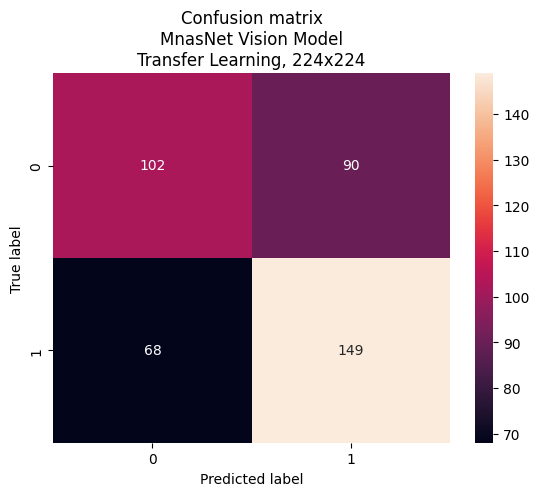